In [10]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import model_utils, file_utils

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnvV2 as StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize


from finrl.plot import backtest_stats

from utils.callbacks import EvalCallback

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
HYPERPARAMETERS_PATH = r'..\experiments\PETR4_012017_122018\TEST_ENV_V2_DDPG_0.05_TECH_FUND\tuning'

In [6]:
env_kwargs = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'env_train_kwargs.json'), 'r'))
args = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'command_line_args.json'), 'r'))
print(env_kwargs, '\n')
print(args)

{'stock_dim': 1, 'initial_amount': 100000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 26, 'action_space': 1, 'tech_indicator_list': ['LPA', 'VPA', 'P/L', 'P/EBITDA', 'P/VPA', 'DL/PL', 'DL/EBITDA', 'ROE', 'MARGEM_EBITDA', 'DL/EBIT', 'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'turbulence_threshold': None, 'print_verbosity': 1000, 'perc_hmax': 0.05} 

{'alg': 'DDPG', 'tickers': ['PETR4.SA'], 'tuning_timesteps': 30000, 'train_timesteps': 200000, 'train_period': ['2017-01-01', '2018-12-31'], 'eval_period': ['2019-01-01', '2019-12-31'], 'trade_period': ['2020-01-01', '2021-12-31'], 'hmax': 0.05, 'use_ohlcv': False, 'initial_amount': 100000, 'n_trials': 20, 'n_repeats_by_trial': 3, 'output_path': '', 'metric_to_optimize': 'Sortino ratio', 'n_eval_episodes': 1, 'use_best_model': True, 'use_fundamental_indicator

In [7]:
TEST_PATH = file_utils.uniquify(os.path.join('TESTS', '_'.join(args['tickers']), args['alg']))
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'monitor_logs'), exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'tb_log'), exist_ok=True)

In [8]:
df_hyperparameters = pd.read_csv(os.path.join(HYPERPARAMETERS_PATH, 'hp_tuning_hist.csv'))
df_hyperparameters_group = df_hyperparameters.groupby(['trial', 'hyperparameters']).agg(['mean', 'std']).reset_index()
df_hyperparameters_group = df_hyperparameters_group.sort_values(('metric', 'mean'), ascending=False)

display(df_hyperparameters_group.head())

print('Best Trial: {} | Mean Metric: {:.4f} +- {:.4f}'.format(
    df_hyperparameters_group.iloc[0]['trial'][0], 
    df_hyperparameters_group.iloc[0][('metric', 'mean')],
    df_hyperparameters_group.iloc[0][('metric', 'std')],
    
    )
)

best_params = eval(df_hyperparameters_group.iloc[0]['hyperparameters'][0])
best_params = model_utils.load_params_from_store_format(best_params)

best_params

trial                                    hyperparameters    metric          
                                                                mean       std
3     3  {'gamma': 0.98, 'learning_starts': 2000, 'lear...  3.005489  0.324313
5     5  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  2.882778  0.714164
4     4  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  2.812927  0.203237
2     2  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  2.560575  0.306806
7     7  {'gamma': 0.98, 'learning_starts': 2000, 'lear...  2.287488  0.975660

Best Trial: 3 | Mean Metric: 3.0055 +- 0.3243


{'gamma': 0.98,
 'learning_starts': 2000,
 'learning_rate': 0.00014271276663404487,
 'batch_size': 64,
 'buffer_size': 100000,
 'train_freq': (64, 'step')}

In [9]:
df = pd.read_pickle(os.path.join(HYPERPARAMETERS_PATH, 'dataset.pkl'))

train_set = data_split(df, args['train_period'][0], args['eval_period'][1])
eval_set = data_split(df, args['eval_period'][0], args['eval_period'][1])
trade_set = data_split(df, args['trade_period'][0], args['trade_period'][1])
# trade_set = data_split(df, args['trade_period'][0], '2019-12-31')

trade_set['date'] = pd.to_datetime(trade_set['date'])

print('Train\t', train_set['close'].iloc[-1] / train_set['close'].iloc[0] - 1)
print('Eval\t', eval_set['close'].iloc[-1] / eval_set['close'].iloc[0] - 1)
print('Trade\t', trade_set['close'].iloc[-1] / trade_set['close'].iloc[0] - 1)

Train	 1.0986822608828
Eval	 0.29602953466536497
Trade	 0.14384809817977207


In [22]:
# RE-TRAINING
e_train_gym = StockTradingEnv(
    df=train_set, 
    **env_kwargs
)
e_train_gym_inv_action = StockTradingEnv(
    df=train_set, 
    **env_kwargs,
    invert_action=True
)

env_train = DummyVecEnv([lambda: e_train_gym, lambda: e_train_gym_inv_action])
env_train = VecMonitor(
    env_train, 
    os.path.join(
        TEST_PATH,
        'monitor_logs',
        'log_retrain'
    )
)
env_train = VecNormalize(
    env_train, 
    training=True,
    norm_obs=True, 
    norm_reward=True,
    gamma=best_params['gamma']
)


MODEL = model_utils.get_model(args['alg'])
retrained_model = MODEL(
    policy='MlpPolicy', 
    env=env_train,
    **best_params,
    verbose=True,
    seed=None,
    tensorboard_log=os.path.join(
        os.path.join(TEST_PATH, 'tb_log')
    )
)

eval_callback = EvalCallback(
    env_train, 
    n_eval_episodes=1,
    eval_freq=int(train_set.shape[0]),
    best_model_save_path=TEST_PATH,
    verbose=False
)

retrained_model = retrained_model.learn(
    tb_log_name='RE_TRAINING',
    log_interval=1,
    total_timesteps=train_set.shape[0] * 10 * retrained_model.env.num_envs,
    callback=[eval_callback],
    reset_num_timesteps=True
)

Using cuda device
Logging to TESTS\PETR4.SA\DDPG\tb_log\RE_TRAINING_2
---------------------------------
| eval/              |          |
|    mean_reward     | 2.01e+04 |
| time/              |          |
|    total_timesteps | 1454     |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 727       |
|    ep_rew_mean     | 52143.812 |
| time/              |           |
|    episodes        | 1         |
|    fps             | 288       |
|    time_elapsed    | 5         |
|    total_timesteps | 1454      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 727       |
|    ep_rew_mean     | 52143.812 |
| time/              |           |
|    episodes        | 2         |
|    fps             | 287       |
|    time_elapsed    | 5         |
|    total_timesteps | 1454      |
----------------------------------


1.5972686504582028


<AxesSubplot:xlabel='date', ylabel='account_value'>

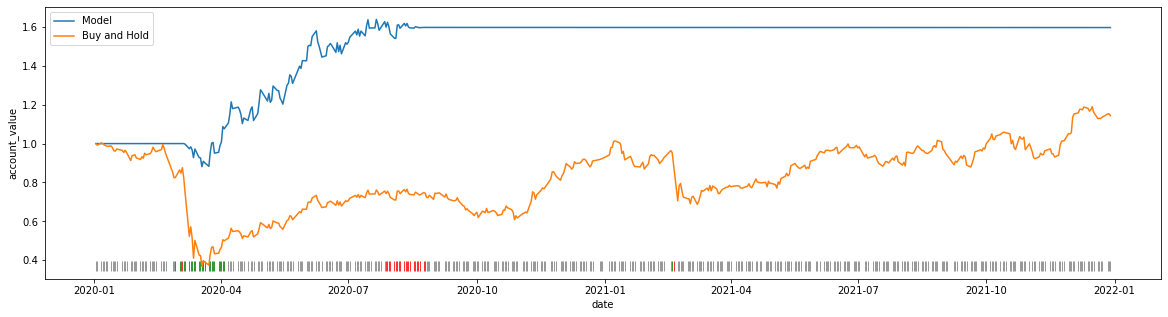

In [21]:
e_eval_gym = StockTradingEnv(df=trade_set, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])
env_eval = VecMonitor(
    env_eval, 
    os.path.join(
        TEST_PATH,
        'monitor_logs',
        'log_trade'
    )
)
env_eval = VecNormalize.load(
    os.path.join(TEST_PATH, 'env_statistics_best'),
    venv=env_eval
)
env_eval.training=False
env_eval.norm_reward=False


account_memory, actions_memory, state_memory = model_utils.predict(
    retrained_model, 
    env_eval, 
    True
)

cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
cum_return_beh = (trade_set['close'].pct_change(1)+1).cumprod().fillna(1)

actions_plot = np.where(
    actions_memory['actions'] > 0, 
    'green', 
    np.where(actions_memory['actions'] < 0,
        'red',
        'gray'
    )
).tolist() + ['gray']

print(cum_return_model.iloc[-1])

plt.figure(figsize=(20,5))
sns.lineplot(x=trade_set['date'], y=cum_return_model, label='Model')
sns.lineplot(x=trade_set['date'], y=cum_return_beh, label='Buy and Hold')


sns.scatterplot(x=trade_set['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)

In [44]:
# from stable_baselines3.common.vec_env import sync_envs_normalization

# e_eval_gym = StockTradingEnv(df=trade_set, **env_kwargs)
# env_eval = DummyVecEnv([lambda: e_eval_gym])
# env_eval = VecMonitor(
#     env_eval, 
#     os.path.join(
#         TEST_PATH,
#         'monitor_logs',
#         'log_trade'
#     )
# )
# env_eval = VecNormalize(
#     env_eval, 
#     training=False,
#     norm_obs=True, 
#     norm_reward=False,
#     gamma=best_params['gamma']
# )

# sync_envs_normalization(env_train, env_eval)

# account_memory, actions_memory, state_memory = model_utils.predict(
#     retrained_model, 
#     env_eval, 
#     True
# )

# cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
# cum_return_beh = (trade_set['close'].pct_change(1)+1).cumprod().fillna(1)

# actions_plot = np.where(
#     actions_memory['actions'] > 0, 
#     'green', 
#     np.where(actions_memory['actions'] < 0,
#         'red',
#         'gray'
#     )
# ).tolist() + ['gray']

# print(cum_return_model.iloc[-1])

# plt.figure(figsize=(20,5))
# sns.lineplot(x=trade_set['date'], y=cum_return_model, label='Model')
# sns.lineplot(x=trade_set['date'], y=cum_return_beh, label='Buy and Hold')


# sns.scatterplot(x=trade_set['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)

USANDO BEST MODEL
TIMESTEPS: 59339


,Model,Buy and Hold
Annual return,0.259957,0.072482
Cumulative returns,0.558644,0.143848
Annual volatility,0.257367,0.580281
Sharpe ratio,1.028308,0.424109
Calmar ratio,0.885012,0.114405
Stability,0.842629,0.398792
Max drawdown,-0.293733,-0.633561
Omega ratio,1.323480,1.089995
Sortino ratio,1.596469,0.567288
Skew,NaN,NaN


1.5586440220502826


<AxesSubplot:xlabel='date', ylabel='account_value'>

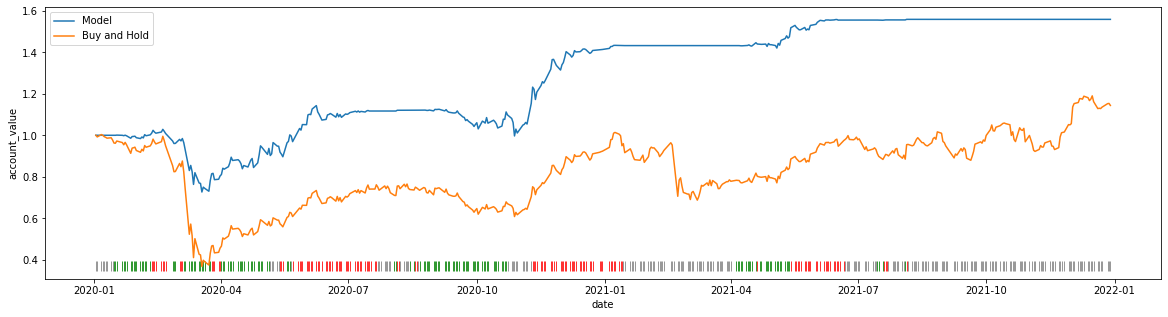

In [45]:
a = 2
b = 0

type = 'best'
dataset = trade_set.copy() #data_split(trade_set, '2020-01-01', '2021-12-31').copy()
dataset['date'] = pd.to_datetime(dataset['date'])

e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])

if args['use_best_model']:
    env_statistics_path = os.path.join(
        HYPERPARAMETERS_PATH, 
        'models',
        'TRIAL_{}_REPEAT_{}'.format(a, b),
        f'env_statistics_{type}'
    )

    env_eval = VecNormalize.load(
        env_statistics_path,
        env_eval,
    )
    env_eval.training = True
    env_eval.norm_reward = False

    best_model_path = os.path.join(
        HYPERPARAMETERS_PATH, 
        f'models',
        'TRIAL_{}_REPEAT_{}'.format(a, b),
        f'model_{type}.zip'
    )

    MODEL = model_utils.get_model(args['alg'])
    trained_model = MODEL.load(best_model_path, env_eval)

    print('USANDO BEST MODEL')
    print('TIMESTEPS:', trained_model.num_timesteps)


account_memory, actions_memory, state_memory = model_utils.predict(
    trained_model, 
    env_eval, 
    True
)

account_temp = pd.DataFrame({
    'date': account_memory['date'],
    'account_value': dataset['close']
})

display(
    pd.concat([
        backtest_stats(account_value=account_memory),
        backtest_stats(account_value=account_temp)
    ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
)

cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

actions_plot = np.where(
    actions_memory['actions'] > 0, 
    'green', 
    np.where(actions_memory['actions'] < 0,
        'red',
        'gray'
    )
).tolist() + ['gray']

print(cum_return_model.iloc[-1])

plt.figure(figsize=(20,5))
sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')


sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)


In [ ]:
df_fundamentals = df_fundamentals.fillna(method='bfill')
df_fundamentals.head()

DS_CONTA,SIGLA,date,EBITDA,FCL CAPEX,Lucro Descontado,Margem Descontada
0,PETR,1996-03-31,2416.0,15359.0,33313.0,20.4
1,PETR,1996-06-30,2416.0,15359.0,33313.0,20.4
2,PETR,1996-09-30,2416.0,15359.0,33313.0,20.4
3,PETR,1996-12-31,2416.0,15359.0,33313.0,20.4
4,PETR,1997-03-31,3652.0,15359.0,33313.0,20.4


In [189]:
actions_memory[actions_memory['actions'] != 0]

,date,actions
0,2019-01-02,[113]
1,2019-01-03,[114]
2,2019-01-04,[113]
3,2019-01-07,[112]
4,2019-01-08,[115]
5,2019-01-09,[119]
6,2019-01-10,[120]
7,2019-01-11,[121]
8,2019-01-14,[124]
9,2019-01-15,[65]


In [56]:
# from stable_baselines3.common.evaluation import evaluate_policy

# evaluate_policy(
#     trained_model,
#     env_eval,
#     n_eval_episodes=2,
#     render=False,
#     deterministic=True,
#     return_episode_rewards=True
# )

([19009.36766976118, 19009.36766976118], [239, 239])

{'gamma': 0.9999,
 'learning_rate': 3.531598691003717e-06,
 'batch_size': 1024,
 'buffer_size': 1000000,
 'train_freq': 8,
 'gradient_steps': 8,
 'policy_kwargs': {'net_arch': [256, 256]}}

In [15]:


for n_repeat in range(10):

    # ENV TRAIN
    e_train_gym = StockTradingEnv(
        df=train_set, 
        **env_kwargs
    )
    env_train = DummyVecEnv([lambda: e_train_gym])
    env_train = VecMonitor(
        env_train, 
        os.path.join(
            TEST_PATH,
            'monitor_logs',
            'log_train_{}'.format(str(n_repeat))
        )
    )
    env_train = VecNormalize(
        env_train, 
        training=True,
        norm_obs=True, 
        norm_reward=True,
        gamma=best_params['gamma']
    )

    MODEL = model_utils.get_model(args['alg'])
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **best_params,
        verbose=True,
        seed=None,
        tensorboard_log=os.path.join(
            TEST_PATH,
            './tb_log'
        )
    )

    trained_model = model.learn(
        tb_log_name='TEST_{}'.format(str(n_repeat)),
        log_interval=1,
        total_timesteps=50000,
        reset_num_timesteps=True
    )

    



    e_eval_gym = StockTradingEnv(df = eval_set, **env_kwargs)
    env_eval = DummyVecEnv([lambda: e_eval_gym])
    
    env_eval = VecNormalize(
        env_eval, 
        training=False,
        norm_obs=True, 
        norm_reward=False,
        gamma=best_params['gamma']
    )

    MODEL = model_utils.get_model(args['alg'])
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **best_params,
        verbose=True,
        seed=None,
        tensorboard_log=os.path.join(
            TEST_PATH,
            './tb_log'
        )
    )



    account_memory, actions_memory = model_utils.predict(trained_model, env_trade)
    test_result = account_memory['account_value'].iloc[-1] / account_memory['account_value'].iloc[0] - 1

    RESULTS_FILE_PATH = os.path.join(TEST_PATH, 'results.csv')

    if not Path(RESULTS_FILE_PATH).exists():
        pd.DataFrame([{'Test': n_repeat, 'Result': test_result}]).to_csv(
            RESULTS_FILE_PATH
        )
    else:
        pd.DataFrame([{'Test': n_repeat, 'Result': test_result}]).to_csv(
            RESULTS_FILE_PATH, mode='a', header=False
        )




Wrapping the env in a DummyVecEnv.


IndexError: invalid index to scalar variable.